### Seasonality in Crypto Trading

**Motivation:**
- Research identifies 22:00 and 23:00 (UTC+0) as hours with significantly higher Bitcoin returns.
- We aim to test these patterns during 2020-2024 to validate their effectiveness.
- If a coin's return during these hours exceeds Bitcoin's return, we generate a long signal.
- If the coin's return is less than or equal to Bitcoin's, we generate a short signal.
- Positions are normalized and rebalanced hourly to maintain a fully invested portfolio.

**Reference:**
https://quantpedia.com/strategies/intraday-seasonality-in-bitcoin/

#### Step 1: Backtest the result of the paper
The original paper tested the strategy from 2015 to 2021. To further validate its effectiveness, we extend the backtesting period to include data up to 2024, using 2020-2024 for our analysis.

In [1]:
from datetime import datetime
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
def compute_turnover(port):
    to = (port.fillna(0)-port.shift().fillna(0)).abs().sum(1)   
    return to

In [3]:
def compute_sharpe_ratio(returns):
    return returns.mean() / returns.std() * np.sqrt(24*252) 

In [4]:
def get_stats(strat_ret):
    stats = {}
    stats['SR'] = strat_ret.mean() / strat_ret.std() * np.sqrt(252*24)
    stats['ret'] = strat_ret.mean()*252*24
    stats['vol'] = strat_ret.std()*np.sqrt(252*24)
    stats = pd.Series(stats)
    return stats

In [5]:
def drawdown(px):
    return (px / (px.expanding(min_periods=1).max()) - 1)

In [6]:
def test_hourly_returns(returns, crypto_name):
    # Extract hour from the index
    hours = returns.index.hour
    
    # Group by hour and calculate mean return, standard deviation, and count for the specified cryptocurrency
    hourly_stats = returns.groupby(hours)[crypto_name].agg(['mean', 'std', 'count'])

    # Calculate T-statistics
    hourly_stats['t_stat'] = hourly_stats['mean'] / (hourly_stats['std'] / np.sqrt(hourly_stats['count']))
    
    # Select only necessary columns and rename for clarity
    result = hourly_stats[['mean', 't_stat']]
    
    return result

In [7]:
def test_weekday_hourly_returns(returns, crypto_name):
    # Extract hour and weekday from the index
    hours = returns.index.hour
    weekdays = returns.index.weekday
    
    # Combine hour and weekday into a multi-index
    returns_grouped = returns.groupby([weekdays, hours])[crypto_name]
    
    # Calculate mean, standard deviation, count, and t-statistics for each weekday-hour combination
    weekday_hourly_stats = returns_grouped.agg(['mean', 'std', 'count'])
    
    # Calculate T-statistics
    weekday_hourly_stats['t_stat'] = weekday_hourly_stats['mean'] / (weekday_hourly_stats['std'] / np.sqrt(weekday_hourly_stats['count']))
    
    # Reshape the DataFrame to have hours as columns and weekdays as rows
    result = weekday_hourly_stats[['mean', 't_stat']].unstack(level=0)
    
    return result

In [8]:
def test_intraweekdays_returns(returns, crypto_name):
    # Create a 'weekday' feature based on the day of the week (Monday=0, Sunday=6)
    weekdays = returns.index.dayofweek
    
    # Group by weekdays and calculate statistics
    returns_grouped = returns.groupby(weekdays)[crypto_name]
    
    # Calculate mean, standard deviation, count, and t-statistics for each weekday
    intraweekdays_stats = returns_grouped.agg(['mean', 'std', 'count'])
    
    # Calculate T-statistics
    intraweekdays_stats['t_stat'] = intraweekdays_stats['mean'] / (intraweekdays_stats['std'] / np.sqrt(intraweekdays_stats['count']))
    
    # Rename the index for clarity
    intraweekdays_stats.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    return intraweekdays_stats

In [9]:
from_pickle = pd.read_pickle('../Data/CoinGecko_px_1H.pkl')
crypto_px = from_pickle
crypto_px 

,VNST,FDUSD,DAR,WETH,USDT,USDC,XRP,SOL,TON,BTC,...,CELR,CLORE,TOKEN,BLZ,BEER,XSGD,SFP,ALPHA,METIS,AGG
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.192493,NaN,NaN,7195.153895,...,0.003559,NaN,NaN,0.015567,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.192267,NaN,NaN,7176.662158,...,0.003562,NaN,NaN,0.015507,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.193050,NaN,NaN,7204.763276,...,0.003594,NaN,NaN,0.015666,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.193580,NaN,NaN,7229.077200,...,0.003622,NaN,NaN,0.015824,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.193394,NaN,NaN,7221.090859,...,0.003623,NaN,NaN,0.015793,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-19 05:00:00,0.000039,0.998958,0.214032,2637.044308,1.000211,0.998089,0.566714,142.317312,6.969696,58587.230439,...,0.010872,0.056665,0.058087,0.132135,0.000011,0.761665,0.733103,0.056023,31.130160,0.000129
2024-08-19 06:00:00,0.000039,1.001013,0.240563,2629.599283,1.000247,1.000268,0.567050,142.625114,6.921028,58504.100944,...,0.010821,0.055548,0.056981,0.131816,0.000011,0.764548,0.732121,0.055963,31.227453,0.000131
2024-08-19 07:00:00,0.000039,1.002329,0.231353,2625.886735,1.000151,1.000394,0.572713,142.916457,6.851694,58566.248972,...,0.010867,0.055493,0.057598,0.132193,0.000011,0.761338,0.731185,0.056482,31.252714,0.000126


In [10]:
# Calculate the total number of data points for each coin
total_data_points = len(crypto_px)

# Calculate the number of non-NA/null entries for each coin
non_null_counts = crypto_px.notnull().sum()

# Calculate the threshold for 95% of data points
threshold = 0.90 * total_data_points

# Filter out coins with less than 95% of data points
crypto_px = crypto_px.loc[:, non_null_counts >= threshold]

crypto_px

,XRP,BTC,ETH,BNB,DOGE,TRX,LTC,LINK,ADA,FTM,...,UTK,IOTA,ONE,ONT,KAVA,BAND,HOT,ZEN,CELR,BLZ
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,0.192493,7195.153895,128.812416,13.683832,0.002026,0.013296,41.176294,1.759009,0.032668,0.010862,...,0.010684,0.160058,0.004548,0.517595,1.123952,0.222692,0.000625,9.133995,0.003559,0.015567
2020-01-01 01:00:00,0.192267,7176.662158,128.859036,13.693838,0.002028,0.013222,41.276043,1.760545,0.032757,0.010905,...,0.010751,0.160234,0.004582,0.516744,1.118914,0.221489,0.000629,9.251777,0.003562,0.015507
2020-01-01 02:00:00,0.193050,7204.763276,130.176809,13.787427,0.002033,0.013345,41.537578,1.779163,0.032935,0.010972,...,0.010813,0.160373,0.004597,0.522013,1.124761,0.220111,0.000630,8.634297,0.003594,0.015666
2020-01-01 03:00:00,0.193580,7229.077200,130.646876,13.834837,0.002023,0.013365,41.760098,1.793839,0.033118,0.010882,...,0.010856,0.160288,0.004641,0.520840,1.131254,0.220316,0.000632,8.417181,0.003622,0.015824
2020-01-01 04:00:00,0.193394,7221.090859,130.105557,13.802292,0.002018,0.013281,41.512371,1.788124,0.032991,0.010817,...,0.010838,0.159786,0.004661,0.518648,1.131902,0.222118,0.000633,8.443030,0.003623,0.015793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-19 05:00:00,0.566714,58587.230439,2633.445935,533.954062,0.100290,0.134463,66.300452,10.114657,0.333643,0.384681,...,0.035451,0.130301,0.010666,0.166674,0.315271,1.066680,0.001357,7.733291,0.010872,0.132135
2024-08-19 06:00:00,0.567050,58504.100944,2620.059478,533.970356,0.100055,0.134602,66.174635,10.091833,0.332597,0.381483,...,0.035663,0.129450,0.010711,0.166572,0.315647,1.071042,0.001354,7.719074,0.010821,0.131816
2024-08-19 07:00:00,0.572713,58566.248972,2630.593135,535.297628,0.100060,0.135110,66.297656,10.154507,0.333506,0.380925,...,0.037421,0.130822,0.010743,0.165555,0.316396,1.069829,0.001369,7.741228,0.010867,0.132193


In [11]:
coins_ret = crypto_px / crypto_px.shift() -1
coins_ret

,XRP,BTC,ETH,BNB,DOGE,TRX,LTC,LINK,ADA,FTM,...,UTK,IOTA,ONE,ONT,KAVA,BAND,HOT,ZEN,CELR,BLZ
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,-0.001172,-0.002570,0.000362,0.000731,0.001144,-0.005593,0.002422,0.000873,0.002702,0.003937,...,0.006285,0.001100,0.007357,-0.001645,-0.004482,-0.005404,0.006129,0.012895,0.000867,-0.003848
2020-01-01 02:00:00,0.004072,0.003916,0.010226,0.006834,0.002247,0.009342,0.006336,0.010575,0.005441,0.006127,...,0.005769,0.000867,0.003268,0.010197,0.005225,-0.006219,0.002646,-0.066742,0.009007,0.010248
2020-01-01 03:00:00,0.002743,0.003375,0.003611,0.003439,-0.004867,0.001496,0.005357,0.008249,0.005557,-0.008204,...,0.003946,-0.000527,0.009576,-0.002247,0.005773,0.000930,0.002451,-0.025146,0.007782,0.010086
2020-01-01 04:00:00,-0.000958,-0.001105,-0.004143,-0.002352,-0.002296,-0.006288,-0.005932,-0.003186,-0.003837,-0.005932,...,-0.001591,-0.003134,0.004429,-0.004209,0.000572,0.008180,0.001355,0.003071,0.000151,-0.001936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-19 05:00:00,0.000480,-0.001328,-0.004925,-0.006002,-0.000663,-0.001280,0.003131,-0.006119,-0.000822,-0.016486,...,-0.015171,0.001893,-0.012808,-0.005641,-0.004730,-0.007762,-0.003309,-0.006291,-0.001768,-0.006799
2024-08-19 06:00:00,0.000593,-0.001419,-0.005083,0.000031,-0.002344,0.001034,-0.001898,-0.002257,-0.003135,-0.008314,...,0.005969,-0.006531,0.004223,-0.000608,0.001192,0.004089,-0.002589,-0.001838,-0.004716,-0.002413
2024-08-19 07:00:00,0.009987,0.001062,0.004020,0.002486,0.000048,0.003773,0.001859,0.006210,0.002733,-0.001463,...,0.049306,0.010602,0.003034,-0.006110,0.002374,-0.001133,0.011006,0.002870,0.004330,0.002856


In [12]:
btc_hourly_stats = test_hourly_returns(coins_ret[:'2021-12-31'], 'BTC')

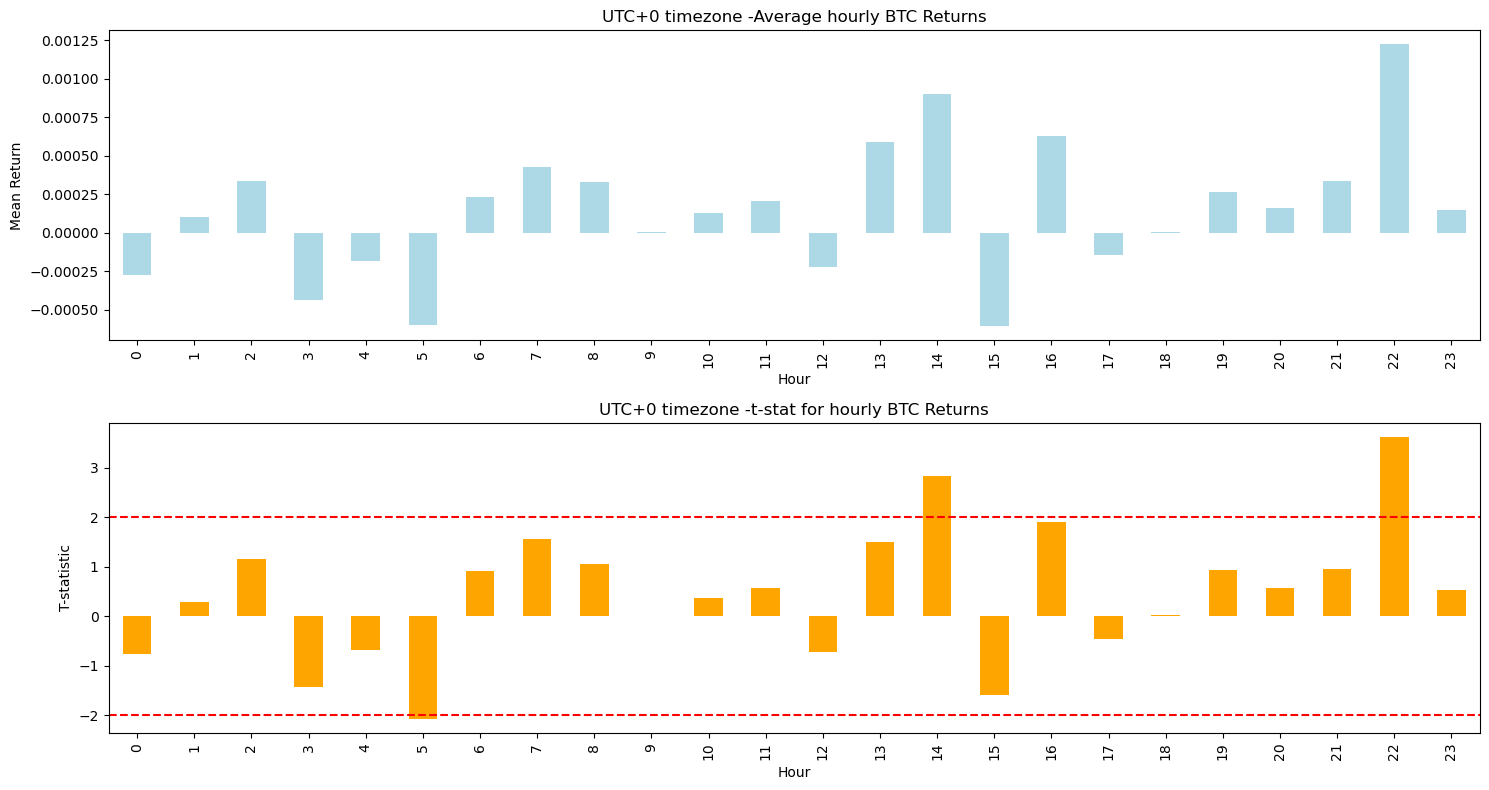

In [13]:
# Plot mean returns and t-statistics for each cryptocurrency
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))

# Plot mean returns
btc_hourly_stats['mean'].plot(kind='bar', ax=axes[0], color='lightblue')
axes[0].set_title(f'UTC+0 timezone -Average hourly BTC Returns')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Mean Return')

# Plot t-statistics
btc_hourly_stats['t_stat'].plot(kind='bar', ax=axes[1], color='orange')
plt.axhline(2.0, color='red', linestyle='--')
plt.axhline(-2.0, color='red', linestyle='--')
axes[1].set_title(f'UTC+0 timezone -t-stat for hourly BTC Returns')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('T-statistic')

plt.tight_layout()
plt.show()

The results indicate that 14:00 and 22:00 show significant returns during 2020-2021, while 23:00 does not exhibit significant returns according to the t-statistics.

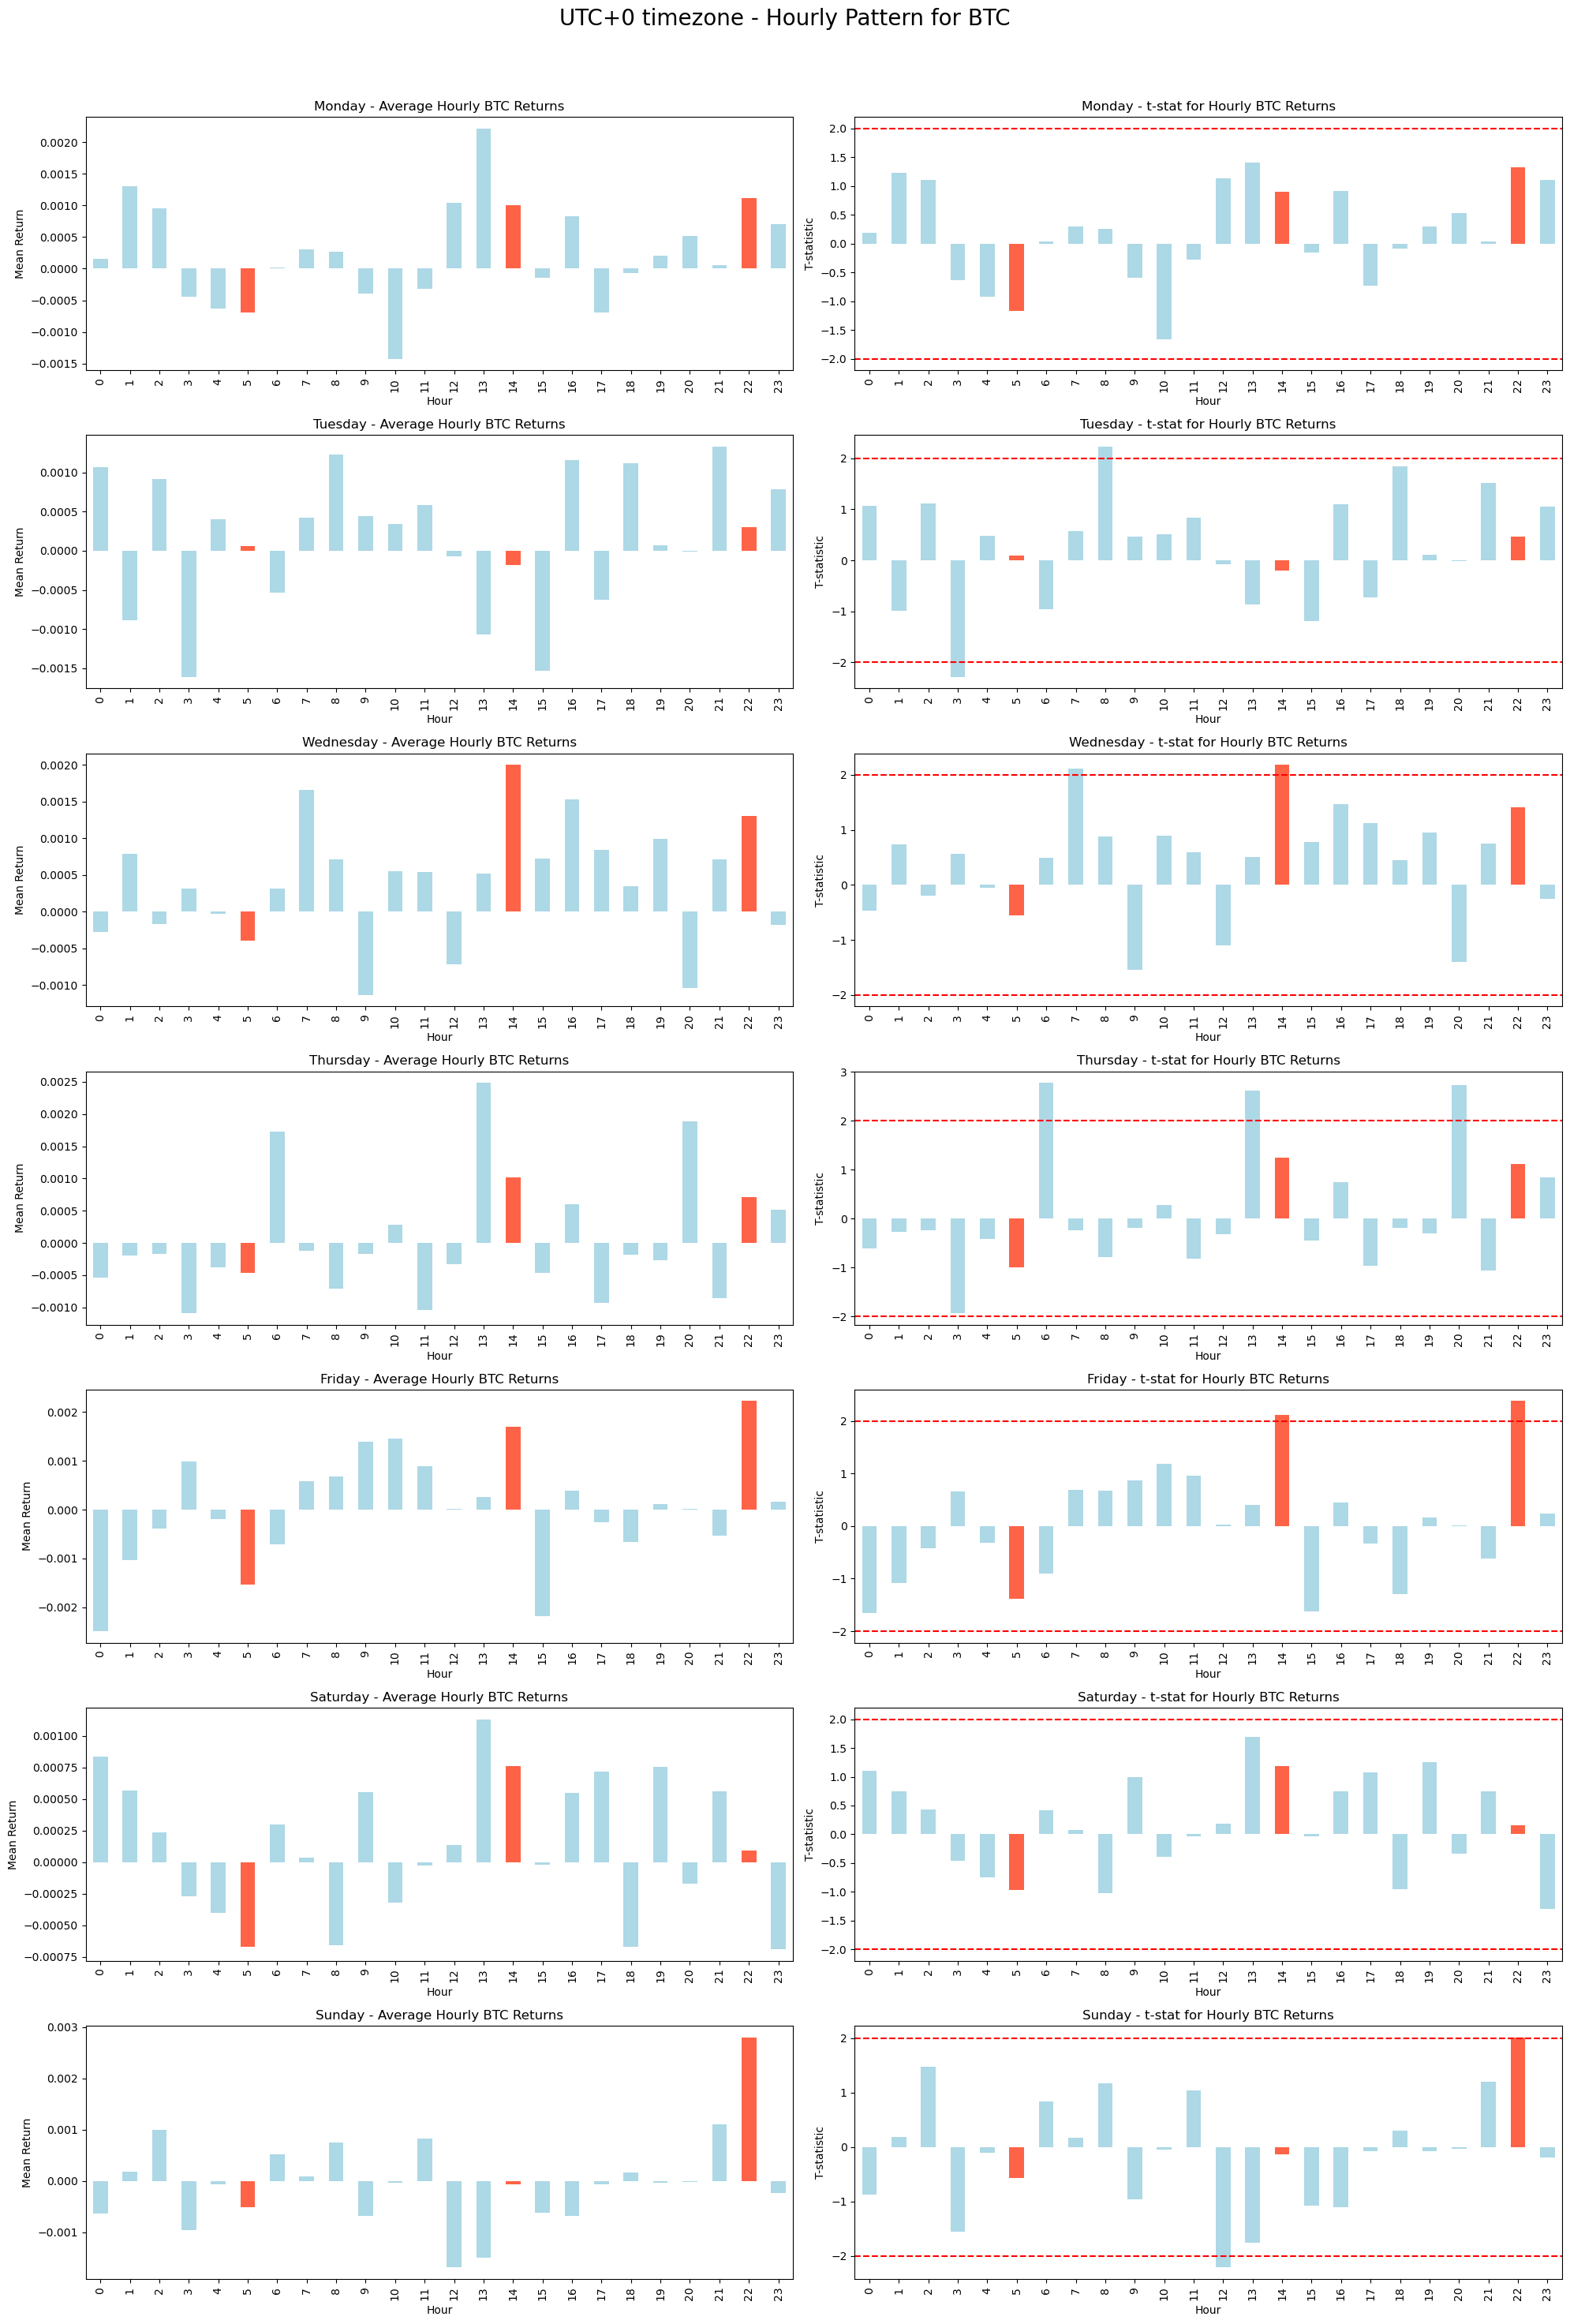

In [14]:
def plot_weekday_hourly_patterns(weekday_hourly_stats, crypto_name):
    fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20, 30))
    fig.suptitle(f'UTC+0 timezone - Hourly Pattern for {crypto_name}', fontsize=20)

    weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # Define highlight hours and their colors
    highlight_hours = [5, 14, 22]
    highlight_color = '#FF6347'  # Tomato
    default_color = 'lightblue'

    for i in range(7):
        # Plot mean returns
        mean_returns = weekday_hourly_stats['mean'].iloc[:, i]
        bars = mean_returns.plot(kind='bar', ax=axes[i, 0], color=[highlight_color if hour in highlight_hours else default_color for hour in mean_returns.index])
        axes[i, 0].set_title(f'{weekday_names[i]} - Average Hourly {crypto_name} Returns')
        axes[i, 0].set_xlabel('Hour')
        axes[i, 0].set_ylabel('Mean Return')

        # Plot t-statistics
        t_stats = weekday_hourly_stats['t_stat'].iloc[:, i]
        bars = t_stats.plot(kind='bar', ax=axes[i, 1], color=[highlight_color if hour in highlight_hours else default_color for hour in t_stats.index])
        axes[i, 1].axhline(2.0, color='red', linestyle='--')
        axes[i, 1].axhline(-2.0, color='red', linestyle='--')
        axes[i, 1].set_title(f'{weekday_names[i]} - t-stat for Hourly {crypto_name} Returns')
        axes[i, 1].set_xlabel('Hour')
        axes[i, 1].set_ylabel('T-statistic')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
btc_hourly_stats = test_weekday_hourly_returns(coins_ret[:'2021-12-31'], 'BTC')
plot_weekday_hourly_patterns(btc_hourly_stats, 'BTC')

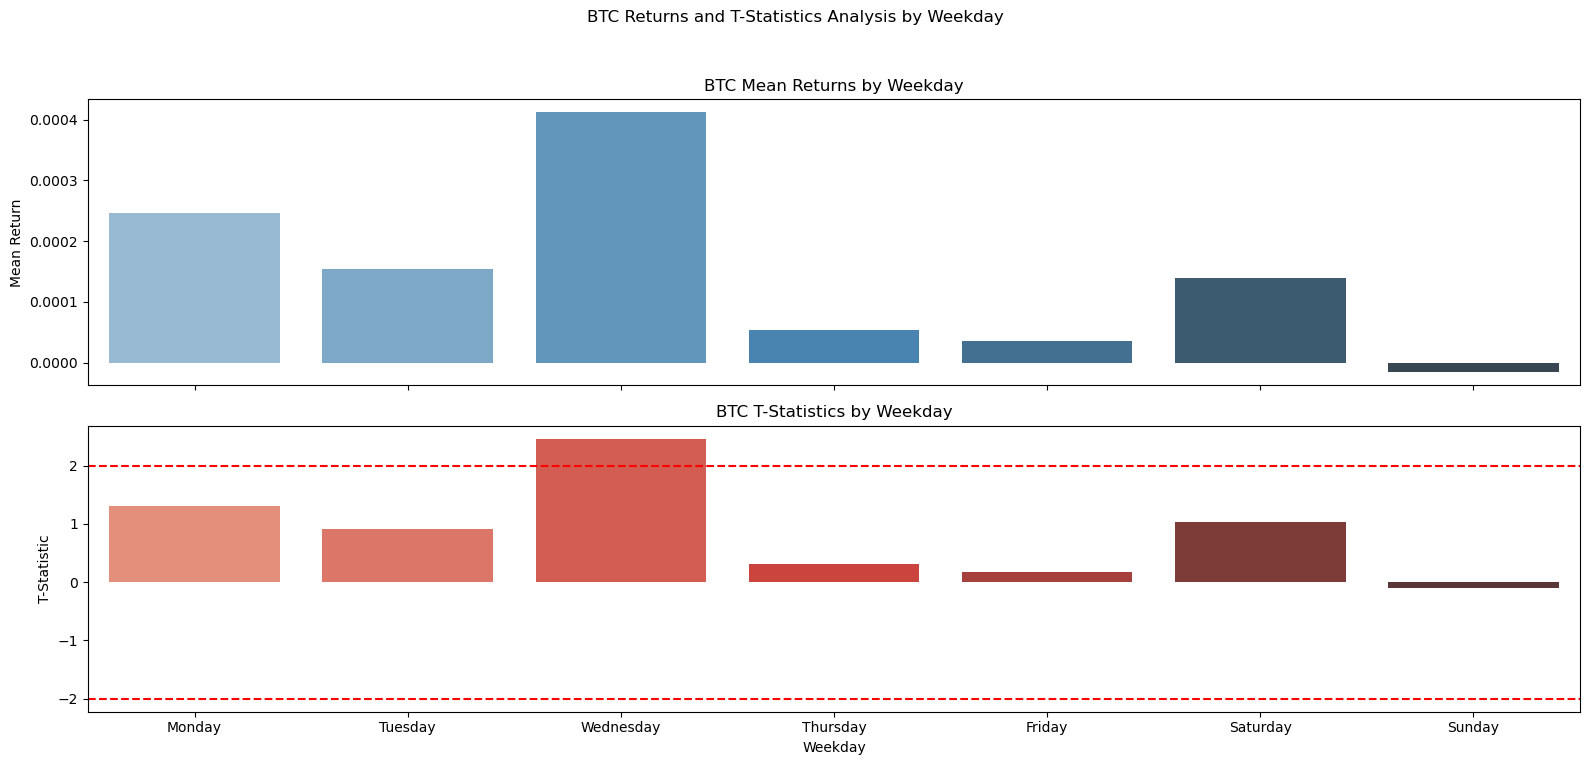

In [15]:
def plot_intraweekdays_stats(intraweekdays_stats, crypto_name):
     # Create a figure with two subplots
    fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
    
    # Plot mean returns
    sns.barplot(x=intraweekdays_stats.index, y=intraweekdays_stats['mean'], palette='Blues_d', ax=ax[0])
    ax[0].set_title(f'{crypto_name} Mean Returns by Weekday')
    ax[0].set_ylabel('Mean Return')
    
    # Plot t-statistics
    sns.barplot(x=intraweekdays_stats.index, y=intraweekdays_stats['t_stat'], palette='Reds_d', ax=ax[1])
    ax[1].set_title(f'{crypto_name} T-Statistics by Weekday')
    ax[1].set_ylabel('T-Statistic')
    ax[1].axhline(2.0, color='red', linestyle='--')
    ax[1].axhline(-2.0, color='red', linestyle='--')
    # Set x-axis label
    ax[1].set_xlabel('Weekday')
    
    # Add title and show plot
    plt.suptitle(f'{crypto_name} Returns and T-Statistics Analysis by Weekday')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
intraweekdays_stats = test_intraweekdays_returns(coins_ret[:'2021-12-31'], 'BTC')
plot_intraweekdays_stats(intraweekdays_stats, 'BTC')

In [16]:
btc_ret = coins_ret['BTC']

btc_strat_pos = pd.DataFrame(0, index=btc_ret.index, columns=['BTC'])

# Buy Bitcoin at 21:00 and 22:00
btc_strat_pos.loc[btc_ret.index.hour == 21, 'BTC'] = 1
btc_strat_pos.loc[btc_ret.index.hour == 22, 'BTC'] = 1

# Exit the position at 23:00
btc_strat_pos.loc[btc_ret.index.hour == 23, 'BTC'] = 0

btc_strat_ret = (btc_strat_pos.shift()*coins_ret).sum(1)

SR     1.471397
ret    0.233728
vol    0.158848
dtype: float64

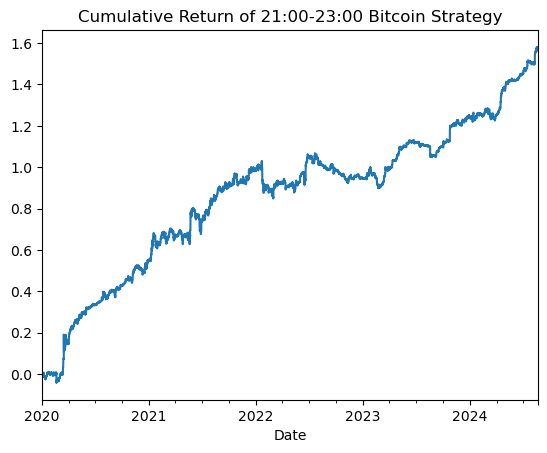

In [17]:
btc_strat_ret.cumsum().plot(title="Cumulative Return of 21:00-23:00 Bitcoin Strategy")
get_stats(btc_strat_ret)

Simply buying Bitcoin at 21:00 and 22:00 UTC+0 and exiting the position at 23:00 achieved a cumulative return of 22.48% with a Sharpe Ratio (SR) of 1.42 during 2020 to 2024.

In [18]:
# Net of transaction costs returns
to = compute_turnover(btc_strat_pos)

tcost_bps = 20 # (commissions + slip)
btc_strat_net_ret = btc_strat_ret.subtract(to * tcost_bps * 1e-4, fill_value=0)

SR    -4.721774
ret   -0.774024
vol    0.163926
dtype: float64

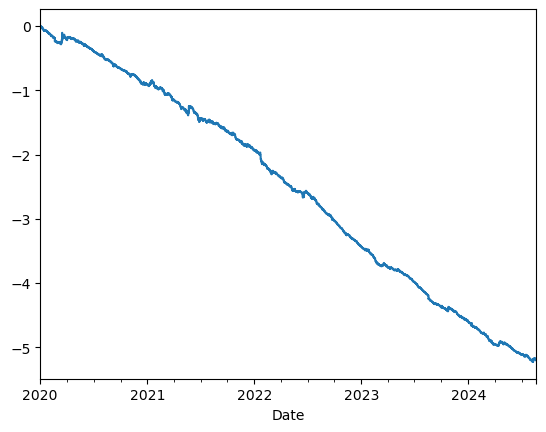

In [19]:
btc_strat_net_ret.cumsum().plot()
get_stats(btc_strat_net_ret)

### Net of Transaction Costs Returns

After transaction costs, the strategy's performance drops sharply (Sharpe -4.78). Despite this, the identified hourly Bitcoin patterns can still be useful for generating signals.

### Step 2: Trading Strategy

#### Version 1: 
Let's test buying Bitcoin at 13:00 and exiting at 14:00, and buying Bitcoin again at 21:00 and exiting at 22:00

In [20]:
btc_ret = coins_ret['BTC']

btc_strat_pos = pd.DataFrame(0, index=btc_ret.index, columns=['BTC'])

# Buy Bitcoin at 21:00 and 22:00
btc_strat_pos.loc[btc_ret.index.hour == 13, 'BTC'] = 1
btc_strat_pos.loc[btc_ret.index.hour == 21, 'BTC'] = 1

# Exit the position at 23:00
btc_strat_pos.loc[btc_ret.index.hour == 14, 'BTC'] = 0
btc_strat_pos.loc[btc_ret.index.hour == 22, 'BTC'] = 0

btc_strat_ret = (btc_strat_pos.shift()*coins_ret).sum(1)

SR     1.518389
ret    0.259498
vol    0.170904
dtype: float64

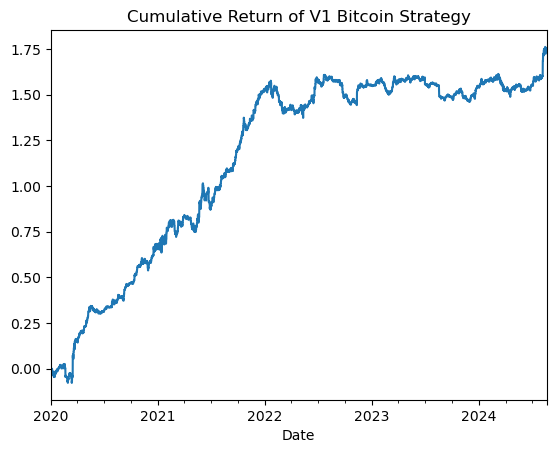

In [21]:
btc_strat_ret.cumsum().plot(title="Cumulative Return of V1 Bitcoin Strategy")
get_stats(btc_strat_ret)

#### Version 2
**Rank Performance**:
- At times 14:00, 21:00, and 22:00 on the previous day, compare the returns of each coin to Bitcoin.
- Rank the coins based on their performance relative to Bitcoin at each of these times.

In [22]:
def gen_port(coins_ret, long_hours_days, short_hours_days, lookback_window, skip_window):
    # Initialize an empty DataFrame for positions
    positions = pd.DataFrame(index=coins_ret.index, columns=coins_ret.columns)
    
    # Set long positions
    for (entry_hour, exit_hour), entry_days in long_hours_days:
        entry_mask = (positions.index.hour == entry_hour) & positions.index.dayofweek.isin(entry_days)
        exit_mask = (positions.index.hour == exit_hour) & positions.index.dayofweek.isin(entry_days)
        
        positions.loc[entry_mask] = 1  # Enter long
        positions.loc[exit_mask] = 0   # Exit long

    # Set short positions
    for (entry_hour, exit_hour), entry_days in short_hours_days:
        entry_mask = (positions.index.hour == entry_hour) & positions.index.dayofweek.isin(entry_days)
        exit_mask = (positions.index.hour == exit_hour) & positions.index.dayofweek.isin(entry_days)
        
        positions.loc[entry_mask] = -1  # Enter short
        positions.loc[exit_mask] = 0    # Exit short
    
    # Forward fill positions to maintain the position until the exit signal
    positions.fillna(method='ffill', inplace=True)
    
    # Shift the returns to skip the most recent window
    shifted_coins_ret = coins_ret.shift(skip_window)
    
    # Calculate moving average of returns, skipping the most recent window
    moving_avg = shifted_coins_ret.rolling(window=lookback_window).mean()
    
    # Rank coins based on their moving average (ascending order)
    rank = moving_avg.rank(axis=1)
    
    # Upweight positions based on ranking
    rank_weighted_positions = positions.multiply(rank, axis=0)
    
    # Normalize positions to ensure fully invested portfolio (equal weight based on rank)
    normalized_positions = rank_weighted_positions.div(rank_weighted_positions.abs().sum(axis=1), axis=0).fillna(0)
    
    return normalized_positions

In [23]:
# Define long hours with corresponding rebalance days
long_hours_days = [  
    ((13, 14), list(range(7))),  # Long all days for 13:00 to 14:00
    ((21, 22), list(range(7))),  # Long all days for 21:00 to 22:00
]

# Define short hours with corresponding rebalance days (if needed)
short_hours_days = []

# Define ranges for lookback and skip windows
lookback_windows = range(24, 73, 4)  # Example: 5 to 50 hours in steps of 5
skip_windows = range(0, 25, 4)  # Example: 1 to 9 hours

# Initialize a DataFrame to store Sharpe ratios
sharpe_matrix = pd.DataFrame(index=lookback_windows, columns=skip_windows)

# Iterate over lookback and skip windows
for lookback in lookback_windows:
    for skip in skip_windows:
        # Generate the portfolio
        port = gen_port(coins_ret[:"2021-12-31"], long_hours_days, short_hours_days, lookback_window=lookback, skip_window=skip)
        
        # Calculate portfolio returns
        strat_gross_ret = (port.shift(1) * coins_ret).sum(axis=1)
        
        # net of tcost returns
        to = compute_turnover(port)
        tcost_bps = 20 # (comissions + slip)
        strat_net_ret = strat_gross_ret.subtract(to*tcost_bps*1e-4,fill_value=0)
        
        # Calculate Sharpe ratio and store in matrix
        sharpe_matrix.loc[lookback, skip] = compute_sharpe_ratio(strat_net_ret)

# Convert to numeric values for the heatmap
sharpe_matrix = sharpe_matrix.astype(float)

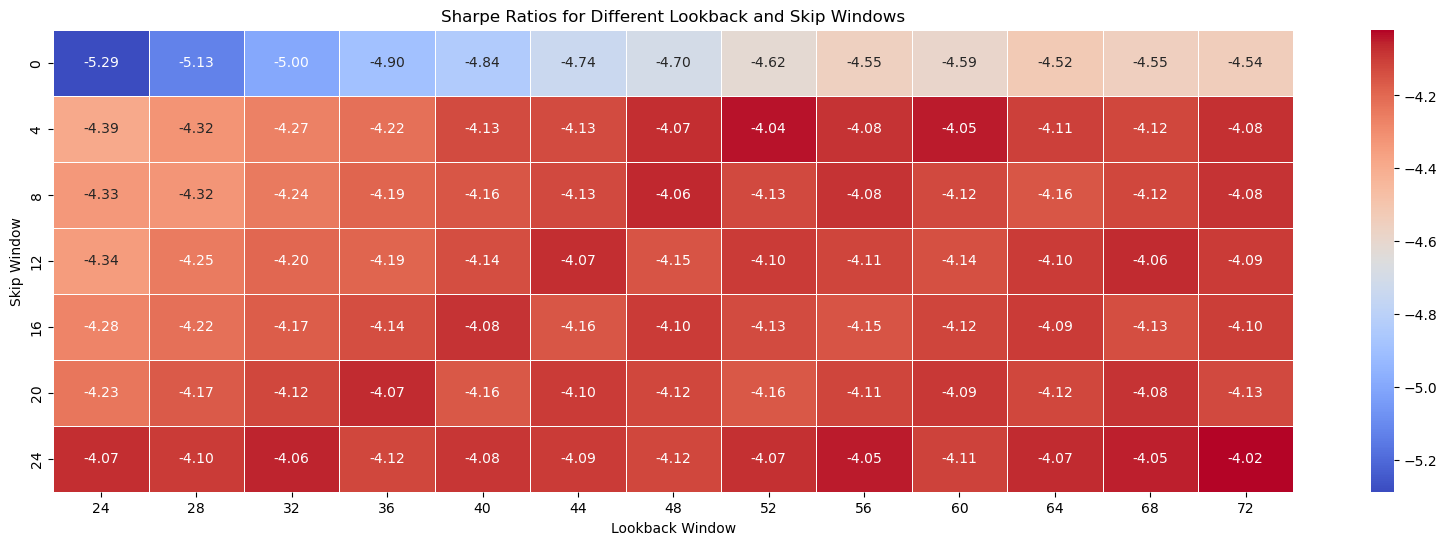

In [24]:
# Plot the heatmap
plt.figure(figsize=(20, 6))
sns.heatmap(sharpe_matrix.T, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.title('Sharpe Ratios for Different Lookback and Skip Windows')
plt.xlabel('Lookback Window')
plt.ylabel('Skip Window')
plt.show()

In [25]:
# full-sample-tests
# Generate portfolio with customized rebalance conditions, moving average ranking, and skipping the recent window
port = gen_port(coins_ret, long_hours_days, short_hours_days, lookback_window=48, skip_window=12)
# port.head(50)

# Inspect the non-zero positions if needed
non_zero_positions = port[port.abs().sum(axis=1) != 0]
non_zero_positions.head(50)

,XRP,BTC,ETH,BNB,DOGE,TRX,LTC,LINK,ADA,FTM,...,UTK,IOTA,ONE,ONT,KAVA,BAND,HOT,ZEN,CELR,BLZ
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-03 13:00:00,0.009818,0.008649,0.014025,0.003506,0.013791,0.009116,0.003740,0.011454,0.015662,0.002805,...,0.006545,0.012389,0.017999,0.009350,0.001636,0.008883,0.008181,0.000468,0.003039,0.019635
2020-01-03 21:00:00,0.004576,0.011210,0.013269,0.005033,0.014871,0.009151,0.007779,0.012354,0.016243,0.002974,...,0.004804,0.015328,0.018760,0.010981,0.009380,0.013956,0.008694,0.005262,0.005720,0.019675
2020-01-04 13:00:00,0.008007,0.013269,0.015328,0.006635,0.013498,0.012583,0.010066,0.005948,0.014642,0.002974,...,0.005720,0.015100,0.014413,0.007550,0.000458,0.004804,0.018989,0.002745,0.007321,0.019218
2020-01-04 21:00:00,0.006863,0.013727,0.013498,0.011439,0.014184,0.011210,0.013269,0.006406,0.013956,0.004118,...,0.001601,0.015100,0.016472,0.010066,0.000686,0.000915,0.018302,0.002517,0.005262,0.020133
2020-01-05 13:00:00,0.006635,0.011439,0.010524,0.010981,0.015328,0.009838,0.014871,0.011897,0.008922,0.007779,...,0.003660,0.017159,0.007092,0.012354,0.003889,0.016930,0.018989,0.007550,0.010295,0.013498
2020-01-05 21:00:00,0.008465,0.012812,0.013269,0.014413,0.015328,0.012125,0.014871,0.007321,0.009609,0.008236,...,0.001601,0.013498,0.002745,0.012583,0.000915,0.010295,0.019446,0.002288,0.005948,0.004118
2020-01-06 13:00:00,0.008922,0.009151,0.012583,0.016472,0.008694,0.010753,0.016015,0.009380,0.009838,0.014642,...,0.000915,0.016701,0.004118,0.016930,0.010066,0.007092,0.011439,0.000458,0.002745,0.003432
2020-01-06 21:00:00,0.012812,0.011668,0.015786,0.014871,0.008007,0.013040,0.016701,0.009151,0.013269,0.010753,...,0.002517,0.018760,0.002059,0.017845,0.007321,0.011210,0.010524,0.001373,0.005262,0.003660
2020-01-07 13:00:00,0.020133,0.015328,0.016243,0.018531,0.003660,0.017159,0.014642,0.013956,0.018760,0.008236,...,0.003203,0.016930,0.002288,0.018989,0.007779,0.005033,0.008922,0.001144,0.003889,0.014184


In [26]:
to = compute_turnover(port)
print(f"The average turnover is {to.mean()}")
print(f"The holding period is {2/to.mean()/24} days")

The average turnover is 0.16332660396868384
The holding period is 0.5102251030047231 days


In [27]:
strat_gross_ret = (port.shift()*coins_ret).fillna(0).sum(1)
print(f"The average strat gross return is {strat_gross_ret.mean()}")

# net of tcost returns
tcost_bps = 20 # (comissions + slip)
strat_net_ret = strat_gross_ret.subtract(to*tcost_bps*1e-4,fill_value=0)
print(f"The average strat net return is {strat_net_ret.mean()}")

The average strat gross return is 3.81638048529671e-05
The average strat net return is -0.00028848940308440056


In [28]:
get_stats(strat_gross_ret)

SR     1.213528
ret    0.230815
vol    0.190201
dtype: float64

<Axes: xlabel='Date'>

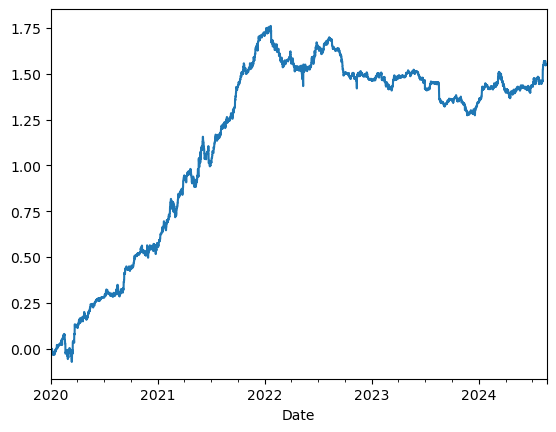

In [29]:
strat_gross_ret.cumsum().plot()

In [30]:
get_stats(strat_net_ret)

SR    -8.868090
ret   -1.744784
vol    0.196749
dtype: float64

<Axes: xlabel='Date'>

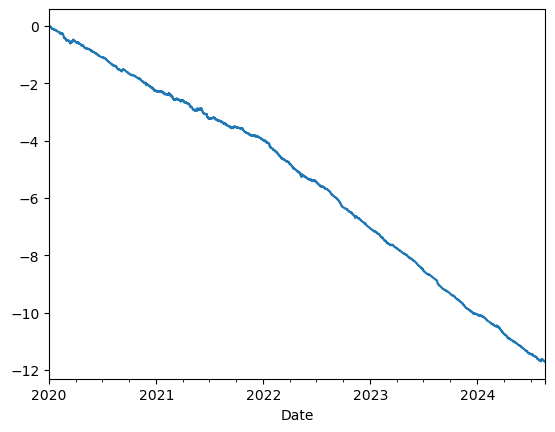

In [31]:
strat_net_ret.cumsum().plot()